In [1]:
import torch
from torch_geometric.data import Data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  

import tensorflow as tf



2024-05-07 18:28:32.886974: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 18:28:37.561327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Graph Dataset Building using Pytorch Geometric

In [57]:
df = pd.read_csv('/filtered_standardized_4sec_time_domain.csv', index_col=0)
df

,0,1,2,3,4,5,6,7,8,9,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
0,-0.549418,-0.647530,-0.593850,-0.314007,0.147774,0.647589,1.010043,1.109238,0.922069,0.531707,...,-0.703665,-1.293908,-1.912303,-2.364613,-2.472726,-2.155340,-1.474396,-0.618555,0.170876,0
1,0.998934,1.147674,0.977642,0.541267,-0.038053,-0.597379,-0.982932,-1.098070,-0.930471,-0.548582,...,0.120385,-0.107278,-0.377166,-0.637484,-0.830237,-0.908732,-0.854699,-0.688762,-0.471740,0
2,0.287015,0.545967,0.647303,0.520136,0.190946,-0.221532,-0.567713,-0.740670,-0.714081,-0.530282,...,-1.326016,-0.718380,-0.165296,0.180676,0.215067,-0.081176,-0.627346,-1.265517,-1.817148,0
3,-1.226938,-1.105112,-0.699707,-0.158344,0.336016,0.639575,0.698537,0.550733,0.283038,-0.021868,...,-0.057975,0.397315,0.791777,1.034483,1.094204,0.998979,0.812872,0.601337,0.405630,0
4,-0.737600,-0.581888,-0.357110,-0.108394,0.134484,0.335471,0.434889,0.367487,0.115937,-0.241025,...,0.419220,0.167055,-0.218238,-0.583097,-0.803984,-0.840613,-0.735065,-0.565198,-0.391111,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.712924,1.090029,1.502158,1.911371,2.286810,2.594749,2.780768,2.768338,2.488391,1.928585,...,-0.478056,-0.678298,-0.832678,-0.925399,-0.960375,-0.953752,-0.923110,-0.881257,-0.836586,17
336,-0.266717,-0.150696,-0.050596,0.014338,0.032602,0.001275,-0.072094,-0.169365,-0.266132,-0.339933,...,-2.263804,-2.413581,-2.457580,-2.421123,-2.358183,-2.336113,-2.407092,-2.580804,-2.814443,17
337,0.904740,1.464853,1.763700,1.742424,1.488705,1.160502,0.874928,0.640902,0.381818,0.026437,...,0.281926,0.305082,0.321300,0.323745,0.318391,0.319304,0.338700,0.378614,0.429720,17
338,-1.444701,-1.250700,-0.950352,-0.589925,-0.224819,0.098785,0.352086,0.523825,0.622689,0.687332,...,-0.079264,-0.090428,-0.054064,0.020493,0.107278,0.178747,0.223074,0.251770,0.289423,17


In [58]:
df.iloc[:,2400].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [59]:
from pandas import DataFrame
from pandas import concat
from numpy import dstack
from tensorflow import keras

def to_3d_input(df1, cols): 
    l=list()
    for i in range(1,7):  # 6 cols
        l.append(df1.iloc[:,(i-1)*cols:i*cols])    # 0-299 accX, 300-599 accY, 600-899 accZ; 900-1199 gyrx, 1200-1499 gyry, 1500-1799 gyrz
    X = dstack(l)
    return X

def rearrange_dataset(features_train, features_test, label_train, label_test):
    #generating 3d input
    features_train = to_3d_input(features_train, 400) # cols is 300 because its 3 sec dataset
    features_test = to_3d_input(features_test, 400)
    
    print("After applying dstack and one hot encoding : ")
    print('features_train : ',features_train.shape)
    print('features_test : ',features_test.shape)
    print('label_train : ',label_train.shape)
    print('label_test : ',label_test.shape,end = '\n\n')

    print(type(label_train))
    print(type(label_test))

    return features_train, features_test, label_train, label_test


def load_to_graph(input_features,label):
    # create graph edges i.e creating edge_index
    edges = []
    timestep = 400
    for node in range(timestep-1):
        edges.append([node,node+1])
        edges.append([node+1,node])

    edge_index = torch.tensor(edges, dtype=torch.long)
    
    graphs_list = []

    for each_sample_index in range(np.shape(input_features)[0]):
        # x = node feature matrix whre x.shape => [ num_nodes, num_node_features]
        x = torch.tensor(input_features[each_sample_index], dtype=torch.float)
        each_graph = Data(x=x, edge_index = edge_index.t().contiguous(), y=torch.tensor(label.iloc[each_sample_index]))
        graphs_list.append(each_graph)
        print(each_graph.validate(raise_on_error=True))
        #logger.info(f"Is {each_sample_index} graph valid : {each_graph.validate(raise_on_error=True)}")
    #logger.info(f"A graph sample's nodes and edges are : {graphs_list[0].num_nodes, graphs_list[0].num_edges}")

    summary = pd.DataFrame(
        [(g.num_nodes, g.num_edges) for g in graphs_list],
        columns=["nodes", "edges"],
    )
    #print(summary)
    #logger.info(f"All graphs summary: {summary.describe().round(1)}")
    return graphs_list 
    

In [60]:
from sklearn.model_selection import train_test_split 

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(X,y , random_state=42, test_size=0.25) 
X_train, X_test, Y_train, Y_test = rearrange_dataset(X_train, X_test, Y_train, Y_test)


#converting numpy data to graphs
name = 'train'
for data in [[X_train,Y_train], [X_test,Y_test]]:
    input_features = data[0]
    label = data[1]
    print(f'type of input_features : {type(input_features)} and type of label is {type(label)}')
    print('Shape of label : ', label.shape,' shape of input_features ', input_features.shape)
    graphs_list = load_to_graph(input_features,label)

    if name == 'train':
        kuhar_train = graphs_list
        name='test'
    elif name == 'test':
        kuhar_test = graphs_list

print(f"Train graph list : {len(kuhar_train)}")
print(f"Test graph list is : {len(kuhar_test)}")

After applying dstack and one hot encoding : 
features_train :  (11655, 400, 6)
features_test :  (3885, 400, 6)
label_train :  (11655,)
label_test :  (3885,)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
type of input_features : <class 'numpy.ndarray'> and type of label is <class 'pandas.core.series.Series'>
Shape of label :  (11655,)  shape of input_features  (11655, 400, 6)
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True

In [61]:
kuhar_test[1]

Data(x=[400, 6], edge_index=[2, 798], y=4)

### Converting lists of graph to InMemoryDataset

In [62]:
# InMemoryDataset constructed from a list of Data objects

from torch_geometric.data import InMemoryDataset

class MyDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        super().__init__(transform)
        self.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        self.save(self.data_list, self.processed_paths[0])

In [63]:
train_dataset = MyDataset(kuhar_train)
#delete the ??? folder created before creating a new dataset object

print(train_dataset.len()) 
train_dataset[10]

Processing...


11655


Done!


Data(x=[400, 6], edge_index=[2, 798], y=[1])

In [64]:
test = MyDataset(kuhar_test)
print(test.len())
test[13]

Processing...


3885


Done!


Data(x=[400, 6], edge_index=[2, 798], y=[1])

In [65]:
print(train_dataset[1].y)
print(train_dataset[10].y)
print(type(train_dataset[0].y))

tensor([4])
tensor([10])
<class 'torch.Tensor'>


### Mini Batching of Graphs

In [66]:
# mini batching of graphs

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[25600, 6], edge_index=[2, 51072], y=[64], batch=[25600], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[25600, 6], edge_index=[2, 51072], y=[64], batch=[25600], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[25600, 6], edge_index=[2, 51072], y=[64], batch=[25600], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[25600, 6], edge_index=[2, 51072], y=[64], batch=[25600], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[25600, 6], edge_index=[2, 51072], y=[64], batch=[25600], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[25600, 6], edge_index=[2, 51072], y=[64], batch=[25600], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[25600, 6], edge_index=[2, 51072], y=[64], batch=[25600], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[25600, 6], edge_inde

### GraphConv 

In [21]:
# Model  - GraphConv

from torch_geometric.nn import GraphConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(6,hidden_channels)  
        self.conv2 = GraphConv(hidden_channels, hidden_channels)  
        self.conv3 = GraphConv(hidden_channels, hidden_channels) 
        self.lin = Linear(hidden_channels, 18)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(6, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=18, bias=True)
)


In [22]:
model = GNN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 30):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.4148, Test Acc: 0.4185
Epoch: 002, Train Acc: 0.4852, Test Acc: 0.4781
Epoch: 003, Train Acc: 0.5148, Test Acc: 0.4991
Epoch: 004, Train Acc: 0.5644, Test Acc: 0.5443
Epoch: 005, Train Acc: 0.5743, Test Acc: 0.5449
Epoch: 006, Train Acc: 0.5915, Test Acc: 0.5634
Epoch: 007, Train Acc: 0.6104, Test Acc: 0.5817
Epoch: 008, Train Acc: 0.6267, Test Acc: 0.5974
Epoch: 009, Train Acc: 0.6266, Test Acc: 0.6005
Epoch: 010, Train Acc: 0.6279, Test Acc: 0.6097
Epoch: 011, Train Acc: 0.6420, Test Acc: 0.6252
Epoch: 012, Train Acc: 0.6483, Test Acc: 0.6296
Epoch: 013, Train Acc: 0.6571, Test Acc: 0.6352
Epoch: 014, Train Acc: 0.6630, Test Acc: 0.6429
Epoch: 015, Train Acc: 0.6606, Test Acc: 0.6416
Epoch: 016, Train Acc: 0.6723, Test Acc: 0.6518
Epoch: 017, Train Acc: 0.6797, Test Acc: 0.6692
Epoch: 018, Train Acc: 0.6759, Test Acc: 0.6559
Epoch: 019, Train Acc: 0.6819, Test Acc: 0.6644
Epoch: 020, Train Acc: 0.6947, Test Acc: 0.6711
Epoch: 021, Train Acc: 0.7000, Test Acc:

### Stacked GNN model

In [39]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch.nn import ModuleList, Linear, Sequential

# Define a simple Graph Neural Network
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(6, hidden_channels) # dataset.num_features, hidden_channels
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, batch)  # Global pooling operation
        return x

# Define the graph classification model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gnns = ModuleList([GNN(hidden_channels=64) for _ in range(3)])  # Stack 3 GNNs
        self.lin1 = Linear(64*3, 128)
        self.lin2 = Linear(128, 18) # 128, dataset.num_classes
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = torch.cat([gnn(x, edge_index, batch) for gnn in self.gnns], dim=1)  # Concatenate GNN outputs
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)



model = Net()
print(model)




Net(
  (gnns): ModuleList(
    (0-2): 3 x GNN(
      (conv1): GCNConv(6, 64)
      (conv2): GCNConv(64, 64)
    )
  )
  (lin1): Linear(in_features=192, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=18, bias=True)
)


In [39]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)



for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Train Acc: 0.4502, Test Acc: 0.4495
Epoch: 002, Train Acc: 0.5894, Test Acc: 0.5898
Epoch: 003, Train Acc: 0.6684, Test Acc: 0.6672
Epoch: 004, Train Acc: 0.7019, Test Acc: 0.6854
Epoch: 005, Train Acc: 0.7233, Test Acc: 0.7058
Epoch: 006, Train Acc: 0.7502, Test Acc: 0.7273
Epoch: 007, Train Acc: 0.7632, Test Acc: 0.7458
Epoch: 008, Train Acc: 0.7629, Test Acc: 0.7408
Epoch: 009, Train Acc: 0.7900, Test Acc: 0.7666
Epoch: 010, Train Acc: 0.7964, Test Acc: 0.7724
Epoch: 011, Train Acc: 0.7964, Test Acc: 0.7676
Epoch: 012, Train Acc: 0.8196, Test Acc: 0.7898
Epoch: 013, Train Acc: 0.8137, Test Acc: 0.7879
Epoch: 014, Train Acc: 0.8240, Test Acc: 0.7908
Epoch: 015, Train Acc: 0.8158, Test Acc: 0.7805
Epoch: 016, Train Acc: 0.8327, Test Acc: 0.7966
Epoch: 017, Train Acc: 0.8386, Test Acc: 0.7981
Epoch: 018, Train Acc: 0.8351, Test Acc: 0.8024
Epoch: 019, Train Acc: 0.8357, Test Acc: 0.8035
Epoch: 020, Train Acc: 0.8500, Test Acc: 0.8116
Epoch: 021, Train Acc: 0.8482, Test Acc:

In [60]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predict = []
y_test = []

for data in test_loader:
    pred = model(data).max(dim=1)[1]
    predict.append(pred) # each time 55 values are predicted, type is torch.Tensor
    y_test.append(data.y)

y_pred = np.concatenate(predict,axis=0)
y_test = np.concatenate(y_test,axis=0)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.73      0.68      0.70       438
           1       0.71      0.55      0.62       497
           2       0.69      0.78      0.73       448
           3       0.90      0.91      0.90       449
           4       0.91      0.98      0.94       567
           5       0.74      0.82      0.78       440
           6       0.91      0.92      0.92       426
           7       0.87      0.89      0.88       314
           8       0.87      0.91      0.89       183
           9       0.63      0.67      0.65       108
          10       0.93      0.78      0.85       279
          11       0.90      0.91      0.91       220
          12       0.99      0.95      0.97        74
          13       0.80      0.72      0.75        60
          14       0.89      0.87      0.88       140
          15       0.88      0.86      0.87       222
          16       0.83      0.86      0.85       196
          17       0.82    

In [40]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch.nn import ModuleList, Linear, Sequential

# Define a simple Graph Neural Network
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(6, hidden_channels) # dataset.num_features, hidden_channels
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, batch)  # Global pooling operation
        return x

# Define the graph classification model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gnns = ModuleList([GNN(hidden_channels=64) for _ in range(5)])  # Stack 3 GNNs
        self.lin1 = Linear(64*5, 128)
        self.lin2 = Linear(128, 18) # 128, dataset.num_classes
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = torch.cat([gnn(x, edge_index, batch) for gnn in self.gnns], dim=1)  # Concatenate GNN outputs
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)



model = Net()
print(model)




Net(
  (gnns): ModuleList(
    (0-4): 5 x GNN(
      (conv1): GCNConv(6, 64)
      (conv2): GCNConv(64, 64)
    )
  )
  (lin1): Linear(in_features=320, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=18, bias=True)
)


In [41]:
# 5 GNNs stacked
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

def train():
    model.train()
    for data in train_loader:
        data = data
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)



for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Train Acc: 0.4448, Test Acc: 0.4376
Epoch: 002, Train Acc: 0.5484, Test Acc: 0.5426
Epoch: 003, Train Acc: 0.6658, Test Acc: 0.6533
Epoch: 004, Train Acc: 0.7152, Test Acc: 0.7089
Epoch: 005, Train Acc: 0.7279, Test Acc: 0.7253
Epoch: 006, Train Acc: 0.7670, Test Acc: 0.7535
Epoch: 007, Train Acc: 0.7686, Test Acc: 0.7580
Epoch: 008, Train Acc: 0.7817, Test Acc: 0.7618
Epoch: 009, Train Acc: 0.7849, Test Acc: 0.7643
Epoch: 010, Train Acc: 0.8051, Test Acc: 0.7784
Epoch: 011, Train Acc: 0.8197, Test Acc: 0.7950
Epoch: 012, Train Acc: 0.8240, Test Acc: 0.7856
Epoch: 013, Train Acc: 0.8166, Test Acc: 0.7792
Epoch: 014, Train Acc: 0.8241, Test Acc: 0.7933
Epoch: 015, Train Acc: 0.8346, Test Acc: 0.8020
Epoch: 016, Train Acc: 0.8460, Test Acc: 0.8107
Epoch: 017, Train Acc: 0.8456, Test Acc: 0.8087
Epoch: 018, Train Acc: 0.8493, Test Acc: 0.8107
Epoch: 019, Train Acc: 0.8322, Test Acc: 0.7966
Epoch: 020, Train Acc: 0.8323, Test Acc: 0.7921
Epoch: 021, Train Acc: 0.8567, Test Acc:

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predict = []
y_test = []

for data in test_loader:
    pred = model(data).max(dim=1)[1]
    predict.append(pred) # each time 55 values are predicted, type is torch.Tensor
    y_test.append(data.y)

y_pred = np.concatenate(predict,axis=0)
y_test = np.concatenate(y_test,axis=0)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.72      0.64      0.68       438
           1       0.69      0.68      0.69       497
           2       0.63      0.77      0.70       448
           3       0.85      0.92      0.88       449
           4       0.97      0.97      0.97       567
           5       0.77      0.82      0.80       440
           6       0.91      0.92      0.92       426
           7       0.92      0.89      0.90       314
           8       0.91      0.92      0.92       183
           9       0.95      0.57      0.72       108
          10       0.89      0.87      0.88       279
          11       0.90      0.93      0.91       220
          12       1.00      0.80      0.89        74
          13       0.78      0.63      0.70        60
          14       0.92      0.91      0.91       140
          15       0.92      0.90      0.91       222
          16       0.90      0.89      0.89       196
          17       0.90    

### Recurrent GNN
To build a recurrent graph neural network (GNN) in PyTorch Geometric, you can use the GatedGraphConv layer along with a recurrent unit such as LSTM or GRU to incorporate sequential information into the graph neural network.

we first define a simple RecurrentGNN class that combines a GatedGraphConv layer with an LSTM layer. The GatedGraphConv layer processes the graph structure, while the LSTM layer processes the node representations sequentially.

In [31]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GatedGraphConv
from torch_geometric.data import Data
from torch.nn import LSTM, Linear

# Define a simple recurrent graph neural network
class RecurrentGNN(torch.nn.Module):
    def __init__(self):
        super(RecurrentGNN, self).__init__()
        self.conv = GatedGraphConv(64, 3) # out_chanels, num_layers
        self.rnn = LSTM(64,64,2) # in_channels, out_channels, num_layers
        self.lin = Linear(64, 18)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = F.relu(x)
        print('shape 1 : ', x.shape)
        #x = x.unsqueeze(0)  # Add batch dimension for RNN
        print('shape 2 : ', x.shape)
        x, _ = self.rnn(x)
        #x = x.squeeze(0)  # Remove batch dimension
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)


model = RecurrentGNN()
print(model)

RecurrentGNN(
  (conv): GatedGraphConv(64, num_layers=3)
  (rnn): LSTM(64, 64, num_layers=2)
  (lin): Linear(in_features=64, out_features=18, bias=True)
)


In [34]:
# Model 3 - GatedGraphConv

from torch_geometric.nn import GatedGraphConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv = GatedGraphConv(64, 3)
        self.lin = Linear(hidden_channels, 18)

    def forward(self, x, edge_index, batch):
        x = self.conv(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return F.log_softmax(x, dim=-1)

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv): GatedGraphConv(64, num_layers=3)
  (lin): Linear(in_features=64, out_features=18, bias=True)
)


In [35]:
model = GNN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 30):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

/home/jasmin/.conda/envs/pytorch/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 001, Train Acc: 0.3803, Test Acc: 0.3733
Epoch: 002, Train Acc: 0.4601, Test Acc: 0.4544
Epoch: 003, Train Acc: 0.4872, Test Acc: 0.4737
Epoch: 004, Train Acc: 0.5075, Test Acc: 0.4912
Epoch: 005, Train Acc: 0.5270, Test Acc: 0.5153
Epoch: 006, Train Acc: 0.5103, Test Acc: 0.4962
Epoch: 007, Train Acc: 0.5551, Test Acc: 0.5485
Epoch: 008, Train Acc: 0.5341, Test Acc: 0.5246
Epoch: 009, Train Acc: 0.5059, Test Acc: 0.4949
Epoch: 010, Train Acc: 0.5447, Test Acc: 0.5319
Epoch: 011, Train Acc: 0.5251, Test Acc: 0.5136
Epoch: 012, Train Acc: 0.5324, Test Acc: 0.5250
Epoch: 013, Train Acc: 0.5432, Test Acc: 0.5458
Epoch: 014, Train Acc: 0.5451, Test Acc: 0.5385
Epoch: 015, Train Acc: 0.5395, Test Acc: 0.5298
Epoch: 016, Train Acc: 0.5354, Test Acc: 0.5364
Epoch: 017, Train Acc: 0.5250, Test Acc: 0.5244
Epoch: 018, Train Acc: 0.5293, Test Acc: 0.5179
Epoch: 019, Train Acc: 0.5159, Test Acc: 0.5124
Epoch: 020, Train Acc: 0.4842, Test Acc: 0.4735
Epoch: 021, Train Acc: 0.5014, Test Acc:

### 4 sec dataset

In [67]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch.nn import ModuleList, Linear, Sequential

# Define a simple Graph Neural Network
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(6, hidden_channels) # dataset.num_features, hidden_channels
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, batch)  # Global pooling operation
        return x

# Define the graph classification model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gnns = ModuleList([GNN(hidden_channels=64) for _ in range(3)])  # Stack 3 GNNs
        self.lin1 = Linear(64*3, 128)
        self.lin2 = Linear(128, 18) # 128, dataset.num_classes
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = torch.cat([gnn(x, edge_index, batch) for gnn in self.gnns], dim=1)  # Concatenate GNN outputs
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)



model = Net()
print(model)

Net(
  (gnns): ModuleList(
    (0-2): 3 x GNN(
      (conv1): GCNConv(6, 64)
      (conv2): GCNConv(64, 64)
    )
  )
  (lin1): Linear(in_features=192, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=18, bias=True)
)


In [68]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

def train():
    model.train()
    for data in train_loader:
        data = data
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)



for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Train Acc: 0.4050, Test Acc: 0.4167
Epoch: 002, Train Acc: 0.5885, Test Acc: 0.5915
Epoch: 003, Train Acc: 0.6366, Test Acc: 0.6309
Epoch: 004, Train Acc: 0.6958, Test Acc: 0.6829
Epoch: 005, Train Acc: 0.7316, Test Acc: 0.7081
Epoch: 006, Train Acc: 0.7411, Test Acc: 0.7169
Epoch: 007, Train Acc: 0.7796, Test Acc: 0.7598
Epoch: 008, Train Acc: 0.7737, Test Acc: 0.7436
Epoch: 009, Train Acc: 0.8071, Test Acc: 0.7732
Epoch: 010, Train Acc: 0.8231, Test Acc: 0.7902
Epoch: 011, Train Acc: 0.8333, Test Acc: 0.7985
Epoch: 012, Train Acc: 0.8340, Test Acc: 0.8003
Epoch: 013, Train Acc: 0.8424, Test Acc: 0.8039
Epoch: 014, Train Acc: 0.8492, Test Acc: 0.8134
Epoch: 015, Train Acc: 0.8426, Test Acc: 0.8147
Epoch: 016, Train Acc: 0.8605, Test Acc: 0.8247
Epoch: 017, Train Acc: 0.8590, Test Acc: 0.8227
Epoch: 018, Train Acc: 0.8401, Test Acc: 0.8031
Epoch: 019, Train Acc: 0.8717, Test Acc: 0.8255
Epoch: 020, Train Acc: 0.8620, Test Acc: 0.8232
Epoch: 021, Train Acc: 0.8710, Test Acc:

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predict = []
y_test = []

for data in test_loader:
    pred = model(data).max(dim=1)[1]
    predict.append(pred) # each time 55 values are predicted, type is torch.Tensor
    y_test.append(data.y)

y_pred = np.concatenate(predict,axis=0)
y_test = np.concatenate(y_test,axis=0)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       349
           1       0.75      0.57      0.65       357
           2       0.73      0.77      0.75       356
           3       0.91      0.95      0.93       353
           4       0.99      0.95      0.97       401
           5       0.87      0.77      0.82       349
           6       0.91      0.97      0.94       331
           7       0.90      0.95      0.93       262
           8       0.75      0.95      0.84       128
           9       0.81      0.69      0.74        84
          10       0.87      0.91      0.89       177
          11       0.92      0.94      0.93       172
          12       0.93      0.87      0.90        60
          13       0.91      0.91      0.91        43
          14       0.83      0.98      0.90       103
          15       0.83      0.91      0.87       147
          16       0.89      0.87      0.88       134
          17       0.90    

### Applying Noise Filters to raw data

In [19]:
(np.arange(20750)/512)

(20750,)

In [4]:
df.iloc[:300,[0,300,600]].values

array([[ 4.2305e-03,  5.0337e-03, -2.0325e-02],
       [ 1.2482e-02, -8.1862e-02,  7.5474e-03],
       [ 1.2127e-02, -1.4245e-02,  5.9104e-02],
       [ 5.2964e-02, -4.3185e-02, -1.9286e-02],
       [-2.0462e-02,  5.4955e-02, -9.1741e-02],
       [ 3.9138e-02,  1.1263e-02,  3.2535e-02],
       [ 2.8608e-02,  1.8592e-02,  1.2242e-02],
       [ 2.1001e-02,  8.9773e-03,  7.0407e-02],
       [ 6.9260e-02, -9.7848e-03,  9.3749e-02],
       [-4.0021e-02, -1.3776e-02,  5.6670e-03],
       [ 2.8898e-02,  6.1522e-03, -2.1334e-03],
       [-1.9202e-03,  2.3163e-02, -1.0536e-02],
       [ 7.1012e-02,  9.8082e-03,  4.4312e-02],
       [ 5.0838e-02,  1.0391e-02,  4.3837e-02],
       [-3.8796e-02, -5.8488e-03, -1.5854e-03],
       [-2.2003e-02,  3.2456e-02, -1.0825e-02],
       [-4.1888e-02, -1.8103e-02, -2.1699e-02],
       [-5.8095e-02,  7.1161e-02, -3.2749e-02],
       [ 1.0598e-02, -3.5656e-02,  8.0177e-02],
       [-2.1517e-02, -4.1562e-02, -1.4716e-02],
       [-8.0649e-02, -2.0798e-02, -7.117

In [4]:
'''
utility functions to apply noise filters and to plot the data has been taken from @author: Kemeng Chen
'''

import os
import sys
import numpy as np 
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D


def median_filter(data, f_size):
	lgth, num_signal=data.shape
	f_data=np.zeros([lgth, num_signal])
	for i in range(num_signal):
		f_data[:,i]=signal.medfilt(data[:,i], f_size)
	return f_data


def freq_filter(data, f_size, cutoff):
	lgth, num_signal=data.shape
	f_data=np.zeros([lgth, num_signal])
	lpf=signal.firwin(f_size, cutoff, window='hamming')
	for i in range(num_signal):
		f_data[:,i]=signal.convolve(data[:,i], lpf, mode='same')
	return f_data

def fft_plot(data, fs, title):
	lgth, num_signal=data.shape
	fqy=np.zeros([lgth,num_signal])
	fqy[:,0]=np.abs(fft(data[:,0]))
	fqy[:,1]=np.abs(fft(data[:,1]))
	fqy[:,2]=np.abs(fft(data[:,2]))
	index=np.arange(int(lgth/2))/(int(lgth/2)/(fs/2))
	fig, ax=plt.subplots()
	labels=['x','y','z']
	color_map=['r', 'g', 'b']
	for i in range(3):
		ax.plot(index, fqy[0:int(lgth/2),i], color_map[i], label=labels[i])
	ax.set_xlim([0, fs/2])
	ax.set_xlabel('Hz')
	ax.set_title('Frequency spectrum: '+title) 
	ax.legend()

def plot_lines(data, fs, title):
	num_rows, num_cols=data.shape
	if num_cols!=3:
		raise ValueError('Not 3D data')
	fig, ax=plt.subplots()
	labels=['x','y','z']
	color_map=['r', 'g', 'b']
	index=np.arange(num_rows)/fs
	for i in range(num_cols):
		ax.plot(index, data[:,i], color_map[i], label=labels[i])
	ax.set_xlim([0,num_rows/fs])
	ax.set_xlabel('Time [sec]')
	ax.set_title('Time domain: '+title)
	ax.legend()

def acc_integration(data):
	num_rows, num_cols=data.shape
	int_data=np.zeros(data.shape)
	for i in range(num_cols):
		int_data[:,i]=TZ_integration(data[:,i])
	return int_data

def plot3D(data, title):
	fig=plt.figure()
	ax=fig.add_subplot(111, projection='3d')
	ax.plot(xs=data[:,0], ys=data[:,1], zs=data[:,2], zdir='z')
	ax.set_title(title)

def calibration(signal):
	inc_eng=np.sum(np.clip(signal, a_min=0, a_max=None))
	der_eng=-1*np.sum(np.clip(signal, a_max=0, a_min=None))
	if inc_eng==0 or der_eng==0:
		raise ValueError('Calibration rule does NOT hold')

	if inc_eng>der_eng:
		beta_p=1
		beta_n=inc_eng/der_eng
		c_signal=(beta_n-1)*np.clip(signal, a_max=0, a_min=None)+signal
	elif der_eng>inc_eng:
		beta_n=1
		beta_p=der_eng/inc_eng
		c_signal=(beta_p-1)*np.clip(signal, a_min=0, a_max=None)+signal
	else:
		c_signal=signal
	return c_signal

def TZ_integration(in_signal):
	lgth=in_signal.shape
	integral=np.zeros(lgth)
	c=0
	for indice, s in enumerate(in_signal):
		if indice==0:
			integral[indice]=c+in_signal[indice]
		else:
			integral[indice]=integral[indice-1]+in_signal[indice]
	return integral

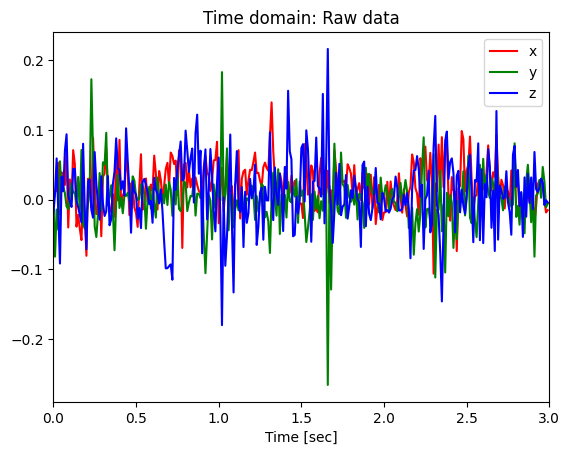

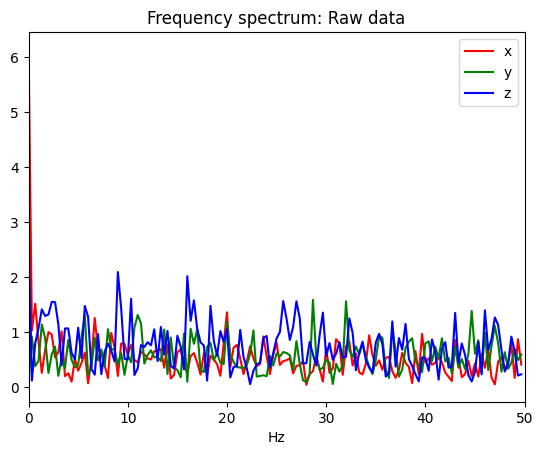

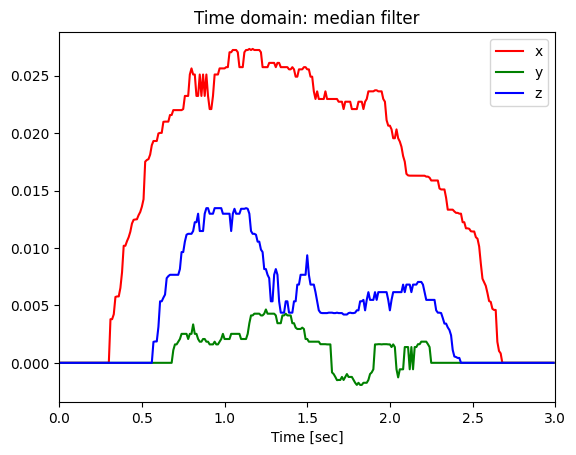

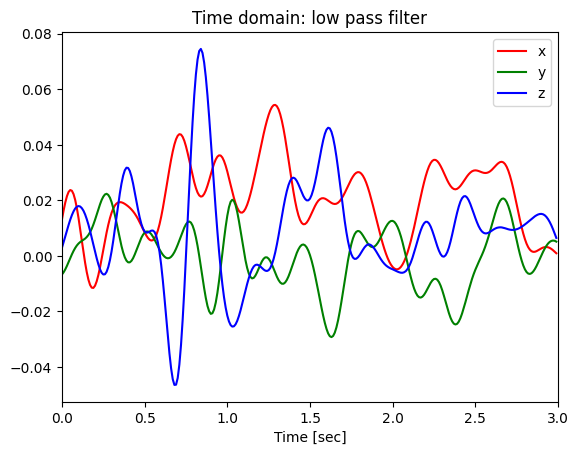

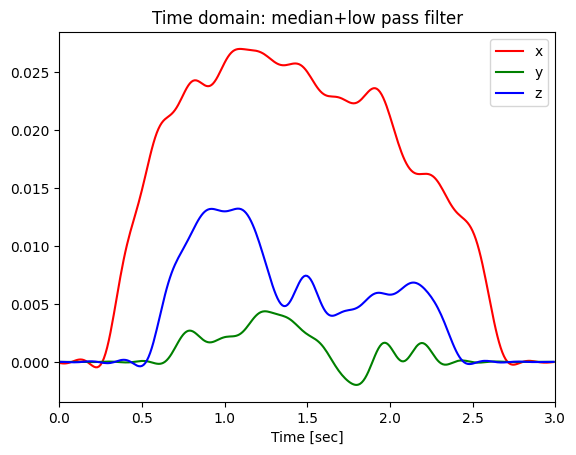

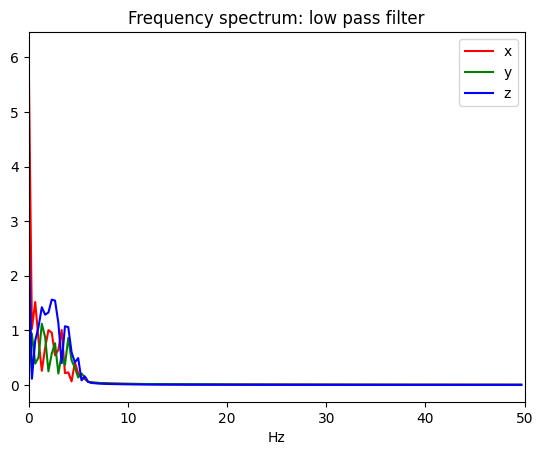

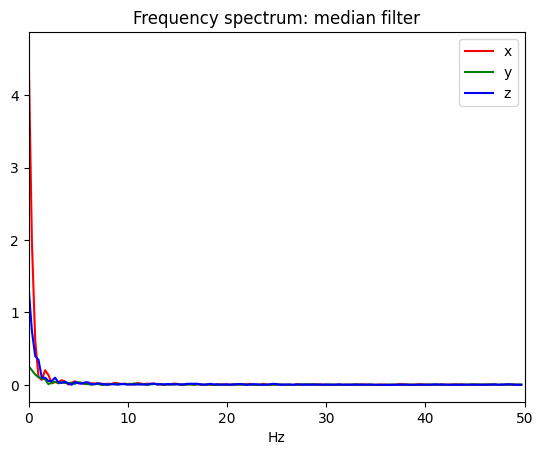

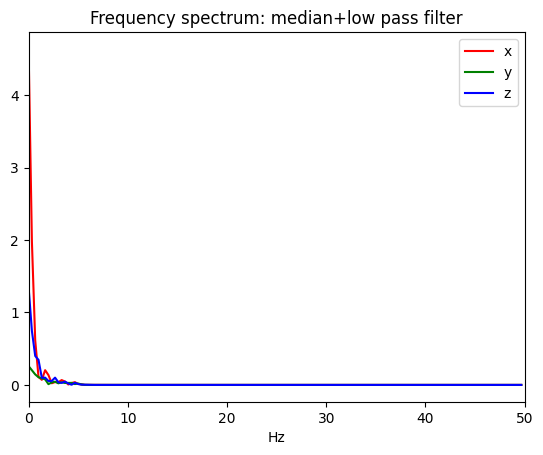

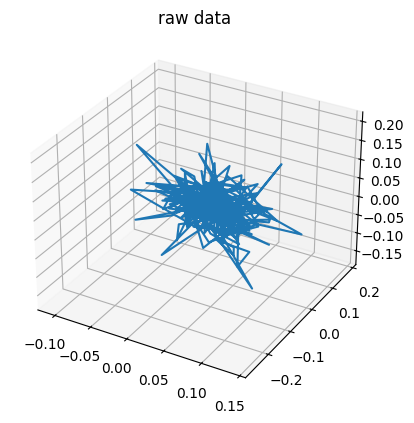

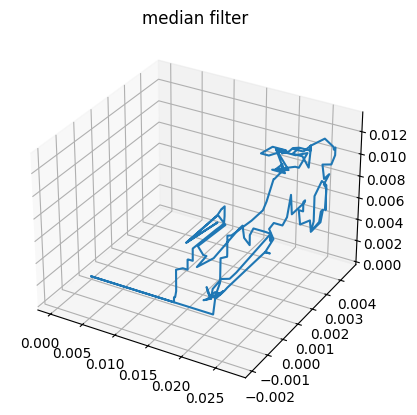

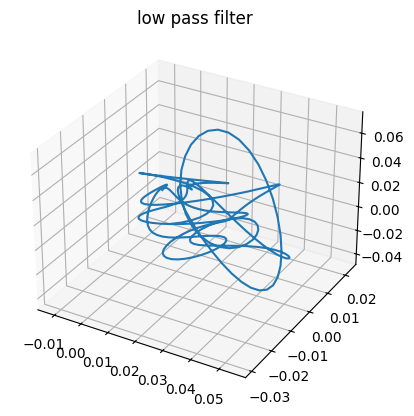

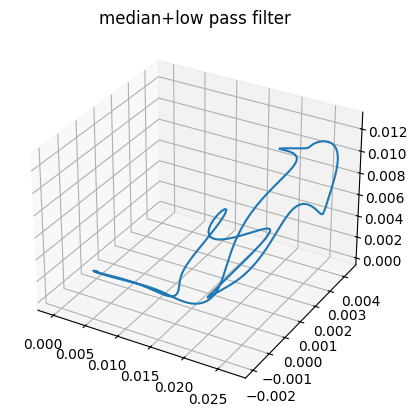

In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt


def test_data(data):
	cur_dir=os.getcwd()
	fs=100
	cutoff=10
	plot_lines(data, fs, 'Raw data')
	fft_plot(data, fs, 'Raw data')
	median_data=median_filter(data, 155)
	lpf_data=freq_filter(data, 155, cutoff/fs)
	comb_data=freq_filter(median_data, 155, cutoff/fs)
	plot_lines(median_data, fs, 'median filter')
	plot_lines(lpf_data, fs, 'low pass filter')
	plot_lines(comb_data, fs, 'median+low pass filter')
	fft_plot(lpf_data, fs, 'low pass filter')
	fft_plot(median_data, fs, 'median filter')
	fft_plot(comb_data, fs, 'median+low pass filter')
	plot3D(data, 'raw data')
	plot3D(median_data, 'median filter')
	plot3D(lpf_data, 'low pass filter')
	plot3D(comb_data, 'median+low pass filter')
	plt.show()

if __name__ == '__main__':
	test_data(df.iloc[:300,[0,300,600]].values)

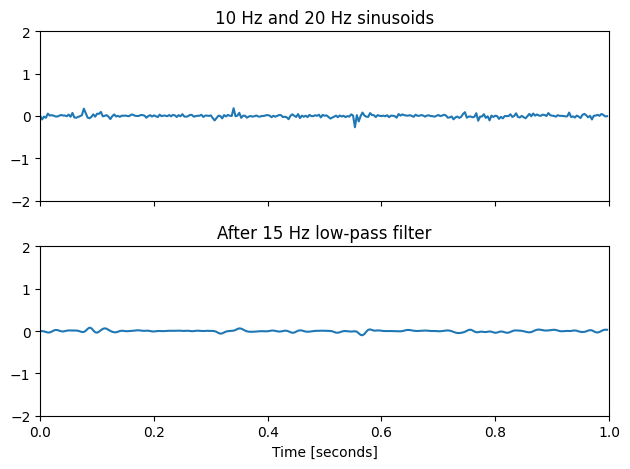

In [52]:
t = np.linspace(0, 1, 300, False)  # 1 second
sig = df.iloc[:300,300].values #np.sin(2*np.pi*100*t) #+ np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

sos = signal.butter(4, 15, 'lp', fs=100, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz low-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()